Hunter Bennett | Glass Lab | Kupffer Strains Project | 07 Feb 2021    

This is a re-vamp of the differential peak calling pipeline for comparisons within strains in a given condition (healthy, CCl4, NASH). This pipeline takes in ATAC-seq peaks annotated with H3K27Ac ChIP-seq data (or other histone modified data) from three strains (c57, balb, and aj) and compares each strain to the other pairwise. The main outputs of this file are:
1. A homer differential peak file containing each pairwise comparison.
2. Scatterplots of each pairwise comparison with significant peaks highlighted.
3. Heatmaps of differential peaks across all comparisons to highlight patterns.
4. Peak files for GREAT analysis of functional annotations associated with genomic regions.

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

In [2]:
dataDirectory = ''
workingDirectory = '/home/h1bennet/strains/results/01_Strains_AMLN_ATAC/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

### Read in raw gene expression files

In [3]:
df, mat = read_annotated_peaks('./merged_peaks/ann_raw_idr_peaks_merged.txt')

In [4]:
mat.columns

Index(['/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/AMLN_30week/00_NCoRWT_Kupffer_ATAC_AMLNDiet_20week_LN203D_JSS_TDT_180425',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/AMLN_30week/00_NCoRWT_Kupffer_ATAC_AMLNDiet_21week_LN170C_JSS_TDT_160919',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/AMLN_30week/00_NCoRWT_Kupffer_ATAC_AMLNDiet_30week_LN136C_JSS_TDT_160919',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/AMLN_30week/00_NCoRWT_Kupffer_ATAC_AMLNDiet_30week_LN141A_JSS_TDT_160921',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/AMLN_30week/01_balbc_Kupffer_ATAC_AMLNDiet_30week_Balb3C_JSS_TDT_160926',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/AMLN_30week/01_balbc_Kupffer_ATAC_AMLNDiet_30week_Balb3D_JSS_TDT_160928',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/AMLN_30week/02_aj_Kupffer_ATAC_AMLNDiet_30week_AJ3A_JSS_TDT_160926',
       '/gpfs/data01/glasslab/home/h1bennet/strai

Select best replicates if filtering in Annotation step supports sample exclusion

In [9]:
best_reps = [
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/AMLN_30week/00_NCoRWT_Kupffer_ATAC_AMLNDiet_20week_LN203D_JSS_TDT_180425',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/AMLN_30week/00_NCoRWT_Kupffer_ATAC_AMLNDiet_21week_LN170C_JSS_TDT_160919',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/AMLN_30week/01_balbc_Kupffer_ATAC_AMLNDiet_30week_Balb3C_JSS_TDT_160926',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/AMLN_30week/01_balbc_Kupffer_ATAC_AMLNDiet_30week_Balb3D_JSS_TDT_160928',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/AMLN_30week/02_aj_Kupffer_ATAC_AMLNDiet_30week_AJ3A_JSS_TDT_160926',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/AMLN_30week/02_aj_Kupffer_ATAC_AMLNDiet_30week_AJ3B_JSS_TDT_160926']

In [10]:
# import annotation file
df, mat = read_annotated_peaks('./merged_peaks/ann_raw_idr_peaks_merged.txt')

# pull out selected samples
tst = np.append(np.asarray([True]*18, 'bool'), mat.columns.str.contains('|'.join(best_reps)))
df= df.loc[:, tst]

df.to_csv('./merged_peaks/ann_raw_idr_peaks_merged_samples_filtered.txt', sep='\t')

In [13]:
df.columns

Index(['Chr', 'Start', 'End', 'Strand', 'Peak Score',
       'Focus Ratio/Region Size', 'Annotation', 'Detailed Annotation',
       'Distance to TSS', 'Nearest PromoterID', 'Entrez ID', 'Nearest Unigene',
       'Nearest Refseq', 'Nearest Ensembl', 'Gene Name', 'Gene Alias',
       'Gene Description', 'Gene Type',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/AMLN_30week/00_NCoRWT_Kupffer_ATAC_AMLNDiet_20week_LN203D_JSS_TDT_180425',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/AMLN_30week/00_NCoRWT_Kupffer_ATAC_AMLNDiet_21week_LN170C_JSS_TDT_160919',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/AMLN_30week/01_balbc_Kupffer_ATAC_AMLNDiet_30week_Balb3C_JSS_TDT_160926',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/AMLN_30week/01_balbc_Kupffer_ATAC_AMLNDiet_30week_Balb3D_JSS_TDT_160928',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/AMLN_30week/02_aj_Kupffer_ATAC_AMLNDiet_30week_AJ3A_JSS_TDT_160926',
       

In [5]:
# %%bash
# source activate deseq_36
# getDiffExpression.pl ./merged_peaks/ann_raw_idr_peaks_merged_samples_filtered.txt \
# 00_c57 00_c57 \
# 01_balbc 01_balbc \
# 02_aj 02_aj \
# -AvsA -peaks > ./merged_peaks/diff_output.txt


### Import differential peaks

In [15]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './merged_peaks/diff_output.txt',
    './merged_peaks/ann_norm_idr_peaks_merged.txt')

annotatePeaks all peaks (61711, 26)
getDiffExpression selected transcripts (60547, 33)
annotatePeaks selected peaks (60547, 26)


In [16]:
# pull out selected samples
cols = np.append(np.asarray([True]*18, 'bool'), peak_mat.columns.str.contains('|'.join(best_reps)))
peaks = peaks.loc[:, tst]
peak_mat = peak_mat.loc[:, peak_mat.columns.str.contains('|'.join(best_reps))]

In [17]:
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

In [18]:
comps = ['00_c57 vs. 01_balbc',
         '00_c57 vs. 02_aj',
         '01_balbc vs. 02_aj']

groups = [[[0,1],[2,3]],
         [[0,1],[4,5]],
         [[2,3],[4,5]]]

cols = []
for i in groups:
    subcols = []
    for j in i:
        subcols.extend([k for k in j])
    cols.append(subcols)

colors = [['#4daf4a', '#377eb8'],
          ['#4daf4a', '#e41a1c'],
          ['#377eb8', '#e41a1c']]

In [13]:
for key, col, group, color in zip(comps, cols, groups, colors):
#     print(key)
#     print('mean calculated using tag dirs:')
#     for colid in peak_mat.iloc[:, col].columns.tolist():
#         print(colid)
#     print('')
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    dot_colors = []
    dot_sizes = []
    for index, row in de.iterrows():
        if (row.adj_pval <= 0.05) & (-row.log2fc < 0):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= 0.05) & (-row.log2fc > 0):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('grey')
            dot_sizes.append(0.5)
    print(key)
    print('N genes downregulated', np.sum((de.adj_pval <= 0.05) & (de.log2fc < 0)))
    print('N genes upregulated', np.sum((de.adj_pval <= 0.05) & (de.log2fc > 0)))
    print('')
    fig, axs = plt.subplots(1, 2, figsize=(10,6))
    plt.subplots_adjust(wspace=0.5)

    axs[0].set_xlim(left=-np.ceil(np.max(np.abs(de.log2fc))),
                right=np.ceil(np.max(np.abs(de.log2fc))))
    axs[0].scatter(
        x=de.log2fc,
        y=de.logtpm,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)

    axs[0].set_ylabel('Mean Log2(TPM)')
    axs[0].set_xlabel('Log2FC')

    # plot group by group scatter:
    axs[1].scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)
    
    axs[1].set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    axs[1].set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    axs[1].set_xlim([0,np.ceil(countmax)])
    axs[1].set_ylim([0,np.ceil(countmax)])
                      
    plt.savefig('./figures/'+key+'_MAPlot_scatter.png', bbox_inches='tight')
    plt.close()
    
    fig, ax = plt.subplots(figsize=(4,4))
    
        # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)
    
    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
    ax.text(0.5,12.5,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)), key.split(' vs. ')[1]),
        fontsize=14,
        c=color[1])
    ax.text(12.5,0.5,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)), key.split(' vs. ')[0]),
        fontsize=14,
        c=color[0],
        rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter.png', bbox_inches='tight')
    plt.close()

00_c57 vs. 01_balbc
N genes downregulated 331
N genes upregulated 195

00_c57 vs. 02_aj
N genes downregulated 169
N genes upregulated 163

01_balbc vs. 02_aj
N genes downregulated 190
N genes upregulated 273



# Cluster differential enhancers:
____
### All enhancers

747


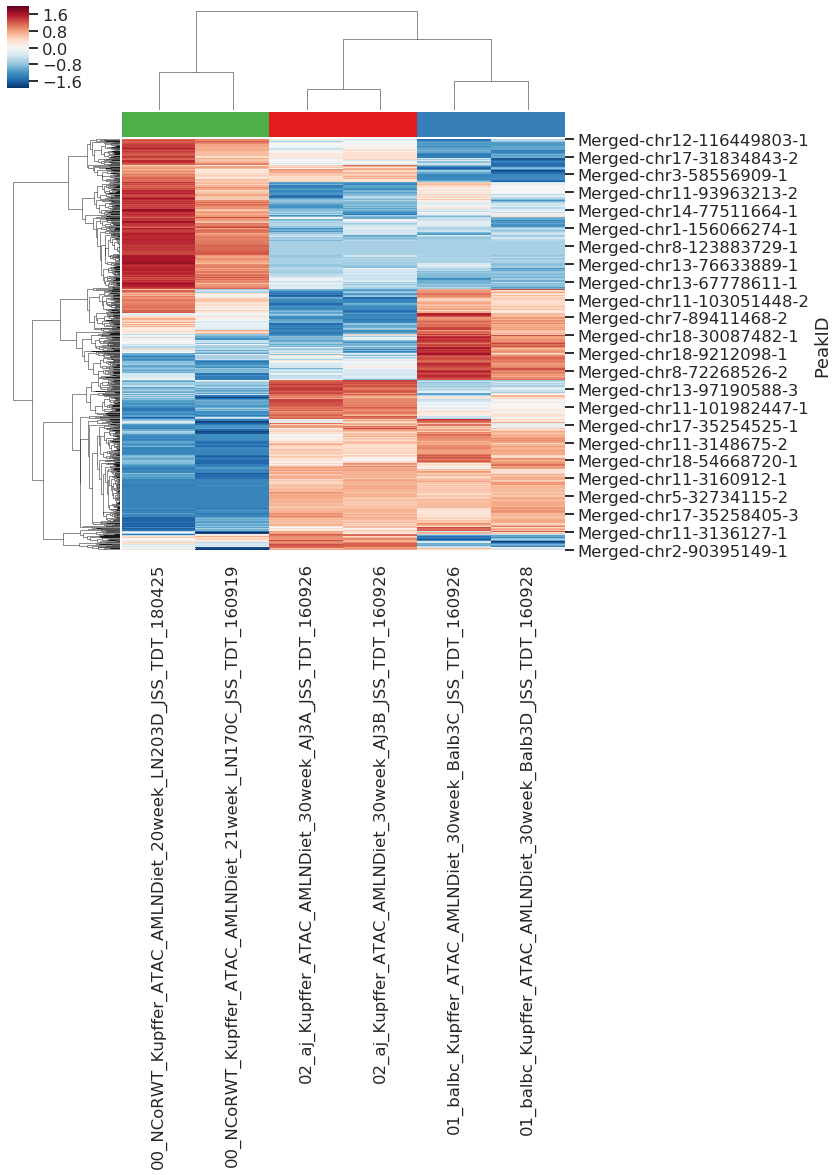

In [21]:
pval = 0.05
fc = 2

# grab differential enhancers for each comparison
sig_peaks_id = []
for comp in comps:
    de = comp_dict[comp]
    sig_peaks_id.extend(de.loc[((de.adj_pval <= pval) & (np.abs(de.log2fc) >= fc)), :].index.tolist())

sig_peaks_id = np.unique(sig_peaks_id)
print(len(sig_peaks_id))
sig_peaks = peak_mat.reindex(sig_peaks_id)
sig_peaks.columns = sig_peaks.columns.str.split('/').str[-1].str.split(' Tag Count').str[0]

sns.clustermap(np.log2(sig_peaks+1),
               z_score=0,
               cmap='RdBu_r',
               col_colors=['#4daf4a', '#4daf4a',
                           '#377eb8', '#377eb8',
                           '#e41a1c', '#e41a1c'])
plt.savefig('./figures/diff_peaks_clustermap.png', bbox_inches='tight')

### distal enhancers only

628


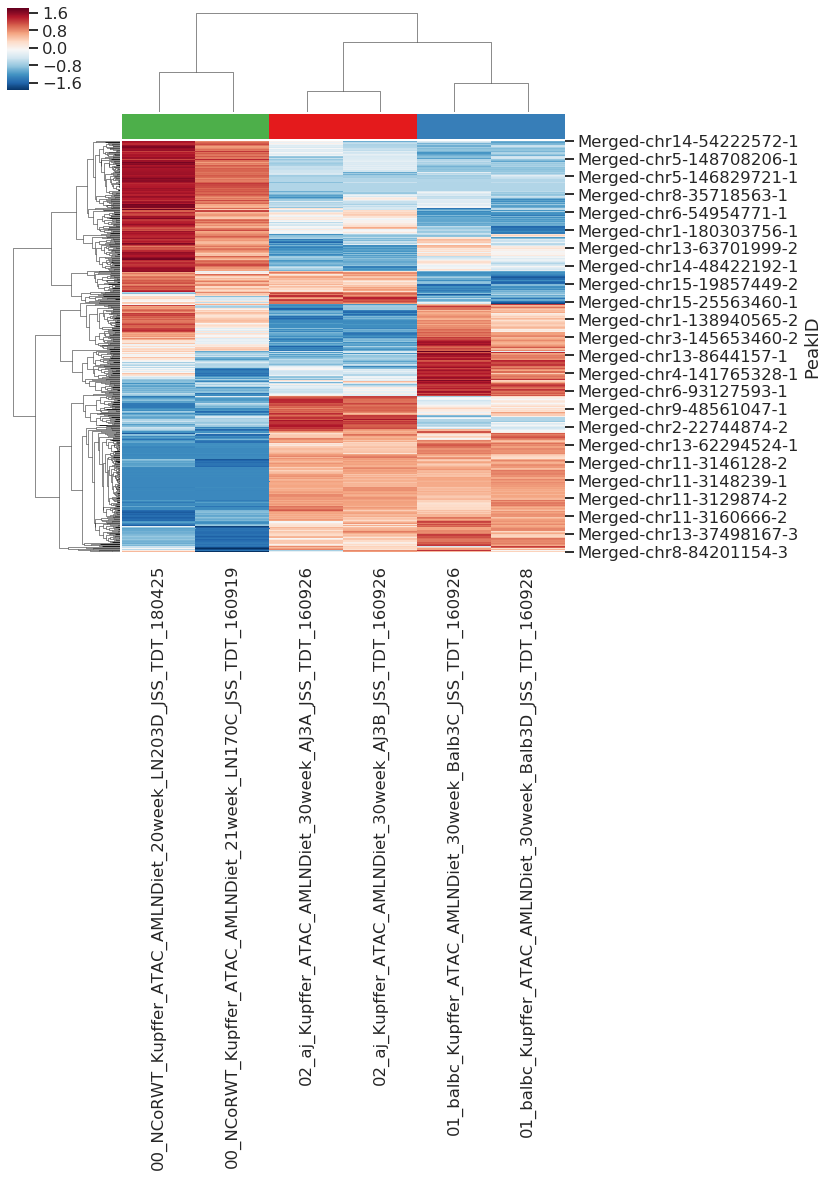

In [22]:
pval = 0.05
fc = 1

# grab differential enhancers for each comparison
sig_peaks_id = []
for comp in comps:
    de = comp_dict[comp]
    sig_peaks_bool = (((de.adj_pval <= pval) & (np.abs(de.log2fc) >= fc)) & (np.abs(de.TSS_dist) >= 3000))
    sig_peaks_id.extend(de.loc[sig_peaks_bool, :].index.tolist())

sig_peaks_id = np.unique(sig_peaks_id)
print(len(sig_peaks_id))
sig_peaks = peak_mat.reindex(sig_peaks_id)
sig_peaks.columns = sig_peaks.columns.str.split('/').str[-1].str.split(' Tag Count').str[0]

sns.clustermap(np.log2(sig_peaks+1),
               z_score=0,
               cmap='RdBu_r',
               col_colors=['#4daf4a', '#4daf4a',
                           '#377eb8', '#377eb8',
                           '#e41a1c', '#e41a1c'])
plt.savefig('./figures/diff_peaks_distal_clustermap.png', bbox_inches='tight')

# Save differential peaks for analysis in GREAT

In [23]:
if not os.path.isdir('./great_analysis/'):
    os.mkdir('./great_analysis/')
    
if not os.path.isdir('./great_analysis/peak_files/'):
    os.mkdir('./great_analysis/peak_files/')
    
if not os.path.isdir('./great_analysis/bed_files/'):
    os.mkdir('./great_analysis/bed_files/')

In [24]:
# initialize dict and list of cell types
peak_lists = {}
bg_lists = {}
cells = ['00_c57',
         '01_balbc',
         '02_aj']

# set pvalue and fc thresholds
fc = np.log2(2)
pval = 0.05

for cell in cells:
    print('Analyzing', cell, '...\n')
    
    # set count
    count = 0
    
    for key in comp_dict.keys():
        
        # select get diff data frame.
        df = comp_dict[key]
        
        # check on counter
        print(count)


        # initialize lists if count == 0
        if count == 0:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        else:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        
        # summarize iteration
        print('For comp:', key)
        print('Union set at:', len(u), 'peaks')
        print('Intersection set at:', len(i), 'peaks\n')
     
    
        # store lists
        peak_lists[cell+'_union'] = u
        peak_lists[cell+'_intersection'] = i

Analyzing 00_c57 ...

0
For comp: 00_c57 vs. 01_balbc
Union set at: 198 peaks
Intersection set at: 198 peaks

1
For comp: 00_c57 vs. 02_aj
Union set at: 271 peaks
Intersection set at: 62 peaks

2
For comp: 01_balbc vs. 02_aj
Union set at: 271 peaks
Intersection set at: 62 peaks

Analyzing 01_balbc ...

0
For comp: 00_c57 vs. 01_balbc
Union set at: 275 peaks
Intersection set at: 275 peaks

1
For comp: 00_c57 vs. 02_aj
Union set at: 275 peaks
Intersection set at: 275 peaks

1
For comp: 01_balbc vs. 02_aj
Union set at: 362 peaks
Intersection set at: 36 peaks

Analyzing 02_aj ...

0
For comp: 00_c57 vs. 01_balbc
Union set at: 362 peaks
Intersection set at: 36 peaks

0
For comp: 00_c57 vs. 02_aj
Union set at: 276 peaks
Intersection set at: 276 peaks

1
For comp: 01_balbc vs. 02_aj
Union set at: 350 peaks
Intersection set at: 44 peaks



if np.NaN get introduced into the matrix then it converts 'int' type columns to 'float' type columns, this is not ideal and interferes with downstream peak analysis so we create a dict to change the start and end columns back to integers just in case

In [25]:
convert_dict = {'Start': int,
                'End': int}

for key in peak_lists.keys():
    # save cell specific promoters
    tmp = diff_peak.reindex(peak_lists[key]).dropna(how='all').iloc[:, :4]
    tmp = tmp.astype(convert_dict)
    tmp.to_csv('./great_analysis/peak_files/'+key+'_poised_peaks.txt',
               sep='\t')

Save full set of peaks for background

In [26]:
diff_peak.iloc[:, :4].to_csv(
    './great_analysis/peak_files/all_peaks.txt',
    sep='\t')

Convert peaks to bed file

In [27]:
%%bash
# delete the existing script file
rm ./peak_to_bed_great.sh
# create a script file
touch ./peak_to_bed_great.sh

rm: cannot remove ‘./peak_to_bed_great.sh’: No such file or directory


In [28]:
%%bash
for peakfile in ./great_analysis/peak_files/*txt;
do bedfile=${i/act/bg};
out=${peakfile/.txt/.bed};
out=${out/peak_files/bed_files}
echo "pos2bed.pl -o $out $peakfile" >> ./peak_to_bed_great.sh
done

# Create bed files for visualization in browser

In [29]:
if not os.path.isdir('./bed_files/'):
    os.mkdir('./bed_files/')

In [30]:
!cp ./great_analysis/bed_files/* ./bed_files/

In [31]:
!ls ./bed_files/

00_c57_intersection_poised_peaks.bed	02_aj_intersection_poised_peaks.bed
00_c57_union_poised_peaks.bed		02_aj_union_poised_peaks.bed
01_balbc_intersection_poised_peaks.bed	all_peaks.bed
01_balbc_union_poised_peaks.bed


In [32]:
with open('./label_bed.sh', 'w') as f:
    for i in glob.glob('./bed_files/*poised_peaks.bed'):
       
        strain = i.split('/')[-1].split('_')[1]
        settype = i.split('/')[-1].split('_')[2]
        group = "AMLN_30weeks"
        chip = 'ATAC'

        # set track names for upload to ucsc genome browser
        lab = "'track name=\"%s_%s_%s_%s\" description=\"%s %s %s %s DESeq2\"'" % (strain, chip, group, settype, strain, group, chip, settype)
        lab_dist = "'track name=\"%s_%s_%s_%s_distal\" description=\"%s %s %s %s DESeq2\"'" % (strain, chip, group, settype, strain, group, chip, settype)

        # set labels - can't think of a more clever way to do this so we will just
        # use the simple if / else statement to switch labels depending on our 
        # peak set being distal or all
        
        if 'distal' in i:
            l = lab_dist
        else:
            l = lab
        
        label_track = ['echo', l, '|', 'cat', '-',
                       i,
                       '> temp && mv temp',
                       i, '\n']
    
        f.write(' '.join(label_track))
        
    f.close()

label all peaks post-hoc

In [33]:
%%bash

echo 'track name="kupffer_AMLN_30weeks_atac_merged" description="Kupffer AMLN 30 weeks ATAC All Strains"' \
| cat - ./bed_files/all_peaks.bed \
> temp && mv temp ./bed_files/all_peaks.bed

# Check differential peak quality in browser

In [34]:
# make location column for peak dict (for examining on browser)
diff_peak['location'] = diff_peak.Chr + ':' + diff_peak.Start.map(str) + '-' + diff_peak.End.map(str)

In [36]:
diff_peak.sort_values('00_c57 vs. 01_balbc adj. p-value', ascending=True).head(20)

,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,...,00_c57 vs. 01_balbc Log2 Fold Change,00_c57 vs. 01_balbc p-value,00_c57 vs. 01_balbc adj. p-value,00_c57 vs. 02_aj Log2 Fold Change,00_c57 vs. 02_aj p-value,00_c57 vs. 02_aj adj. p-value,01_balbc vs. 02_aj Log2 Fold Change,01_balbc vs. 02_aj p-value,01_balbc vs. 02_aj adj. p-value,location
PeakID,,,,,,,,,,,,,,,,,,,,,
Merged-chr1-24612753-3,chr1,24612654,24612854,+,1000.000000,./atac_peak_files/aj_kupffer_amln_30weeks.idr|...,Intergenic,Intergenic,-25317.0,NM_007733,...,-2.397254,1.430078e-21,8.658120e-17,-0.451072,5.964868e-02,7.056787e-01,1.939869,6.982699e-07,0.000811,chr1:24612654-24612854
Merged-chr11-3174397-2,chr11,3174288,3174488,+,1000.000000,./atac_peak_files/aj_kupffer_amln_30weeks.idr|...,"intron (NM_030207, intron 6 of 32)",PB1D11|SINE|Alu,19075.0,NM_030207,...,9.631511,6.666004e-20,2.017899e-15,8.272900,1.755470e-14,2.043297e-10,-1.370321,3.793366e-07,0.000507,chr11:3174288-3174488
Merged-chr11-3174071-3,chr11,3173972,3174172,+,924.833313,./atac_peak_files/aj_kupffer_amln_30weeks.idr|...,"intron (NM_030207, intron 6 of 32)","intron (NM_030207, intron 6 of 32)",19391.0,NM_030207,...,3.098436,8.181853e-17,1.651180e-12,2.092486,5.661856e-06,1.997023e-03,-1.027903,3.105997e-04,0.060596,chr11:3173972-3174172
Merged-chr11-3157018-2,chr11,3156928,3157128,+,1000.000000,./atac_peak_files/aj_kupffer_amln_30weeks.idr|...,"intron (NM_030207, intron 11 of 32)","intron (NM_030207, intron 11 of 32)",33007.0,NR_003517,...,7.768452,5.607011e-13,8.486632e-09,7.172011,7.028490e-11,2.045220e-07,-0.595519,2.797851e-02,0.506940,chr11:3156928-3157128
Merged-chr11-3157612-2,chr11,3157493,3157693,+,1000.000000,./atac_peak_files/aj_kupffer_amln_30weeks.idr|...,"intron (NM_030207, intron 11 of 32)","intron (NM_030207, intron 11 of 32)",33572.0,NR_003517,...,10.250931,4.759609e-12,5.763220e-08,9.757567,6.629446e-11,2.030634e-07,-0.500988,7.303137e-02,0.677419,chr11:3157493-3157693
Merged-chr11-3157920-2,chr11,3157817,3158017,+,1000.000000,./atac_peak_files/aj_kupffer_amln_30weeks.idr|...,"exon (NM_030207, exon 11 of 33)","exon (NM_030207, exon 11 of 33)",33896.0,NR_003517,...,10.057164,1.270262e-11,1.281757e-07,9.365155,5.025664e-10,1.000565e-06,-0.699794,1.294908e-02,0.382382,chr11:3157817-3158017
Merged-chr5-114175771-3,chr5,114175661,114175861,+,948.666687,./atac_peak_files/aj_kupffer_amln_30weeks.idr|...,"intron (NM_133904, intron 1 of 51)","intron (NM_133904, intron 1 of 51)",10243.0,NM_133904,...,3.292078,1.680844e-10,1.453762e-06,2.015548,2.732231e-03,1.913445e-01,-1.295571,4.524393e-04,0.073512,chr5:114175661-114175861
Merged-chr11-3156728-1,chr11,3156628,3156828,+,1000.000000,./atac_peak_files/aj_kupffer_amln_30weeks.idr,"intron (NM_030207, intron 12 of 32)",ID_B1|SINE|B4,32707.0,NR_003517,...,5.320343,2.429078e-10,1.838296e-06,5.752913,2.726178e-13,2.266544e-09,0.428803,2.256330e-01,0.855805,chr11:3156628-3156828
Merged-chr4_GL456216_random-17329-1,chr4_GL456216_random,17229,17429,+,1000.000000,./atac_peak_files/c57bl6j_kupffer_amln_30weeks...,"intron (NM_001033326, intron 1 of 6)","intron (NM_001033326, intron 1 of 6)",1448.0,NM_001033326,...,-9.292251,5.394699e-10,3.629014e-06,-8.908556,2.803355e-09,3.471269e-06,NaN,1.000000e+00,1.000000,chr4_GL456216_random:17229-17429


### Balb specific enhancer example

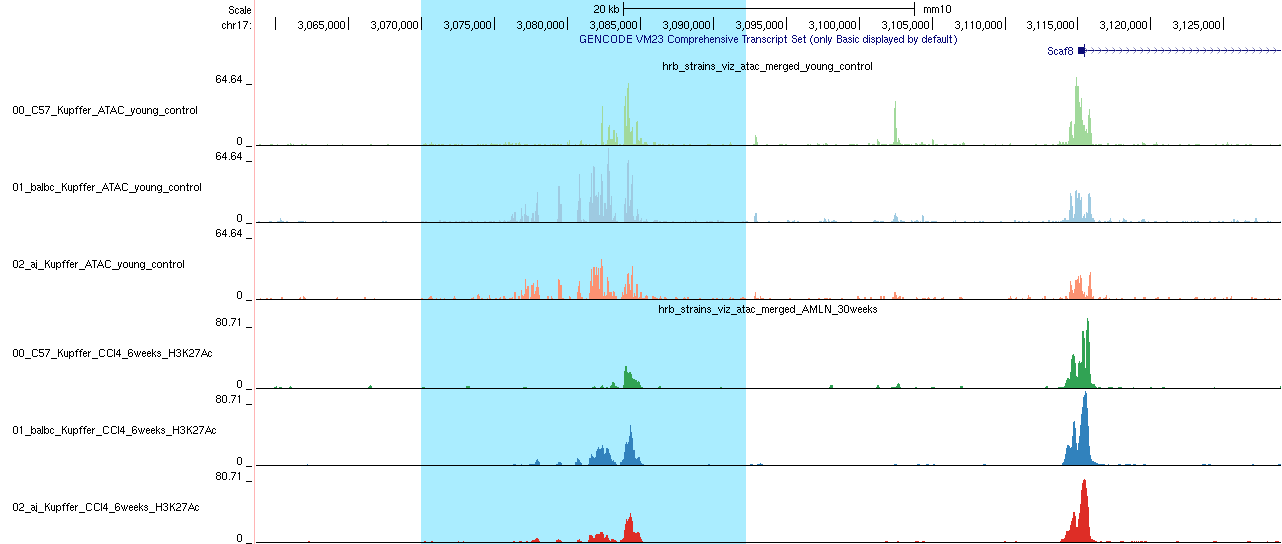